In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

In [47]:
RAND_STATE = 42 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

In [48]:
df= pd.read_csv("Data_MidTerm_Project_Real_State_Regression.csv")

In [49]:
df

id        date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0      7129300520  13/10/2014         3       1.00         1180      5650   
1      6414100192  09/12/2014         3       2.25         2570      7242   
2      5631500400  25/02/2015         2       1.00          770     10000   
3      2487200875  09/12/2014         4       3.00         1960      5000   
4      1954400510  18/02/2015         3       2.00         1680      8080   
...           ...         ...       ...        ...          ...       ...   
21592   263000018  21/05/2014         3       2.50         1530      1131   
21593  6600060120  23/02/2015         4       2.50         2310      5813   
21594  1523300141  23/06/2014         2       0.75         1020      1350   
21595   291310100  16/01/2015         3       2.50         1600      2388   
21596  1523300157  15/10/2014         2       0.75         1020      1076   

       floors  waterfront  view  condition  ...  sqft_above  sqft_basement  \
0         1.0           0     0          3  ...        1180              0   
1         2.0           0     0          3  ...        2170            400   
2         1.0           0     0          3  ...         770              0   
3         1.0           0     0          5  ...        1050            910   
4         1.0           0     0          3  ...        1680              0   
...       ...         ...   ...        ...  ...         ...            ...   
21592     3.0           0     0          3  ...        1530              0   
21593     2.0           0     0          3  ...        2310              0   
21594     2.0           0     0          3  ...        1020              0   
21595     2.0           0     0          3  ...        1600              0   
21596     2.0           0     0          3  ...        1020              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0          1955             0    98178  47.5112 -122.257           1340   
1          1951          1991    98125  47.7210 -122.319           1690   
2          1933             0    98028  47.7379 -122.233           2720   
3          1965             0    98136  47.5208 -122.393           1360   
4          1987             0    98074  47.6168 -122.045           1800   
...         ...           ...      ...      ...      ...            ...   
21592      2009             0    98103  47.6993 -122.346           1530   
21593      2014             0    98146  47.5107 -122.362           1830   
21594      2009             0    98144  47.5944 -122.299           1020   
21595      2004             0    98027  47.5345 -122.069           1410   
21596      2008             0    98144  47.5941 -122.299           1020   

       sqft_lot15   price  
0            5650  221900  
1            7639  538000  
2            8062  180000  
3            5000  604000  
4            7503  510000  
...           ...     ...  
21592        1509  360000  
21593        7200  400000  
21594        2007  402101  
21595        1287  400000  
21596        1357  325000  

[21597 rows x 21 columns]

In [50]:
from scipy.stats import iqr
def remove_outliers(df):
    for c in df.columns:
            pct_75 = np.percentile(df[c], 75)
            pct_25 = np.percentile(df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(df[c])
            lower_bound = pct_25 - 1.5*iqr(df[c])
            condition = (df[c] < upper_bound) & (df[c] > lower_bound)
            df[c] = df[c][condition]  # Filter out the outliers
    return df

In [51]:
df.columns # inspect the column names

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

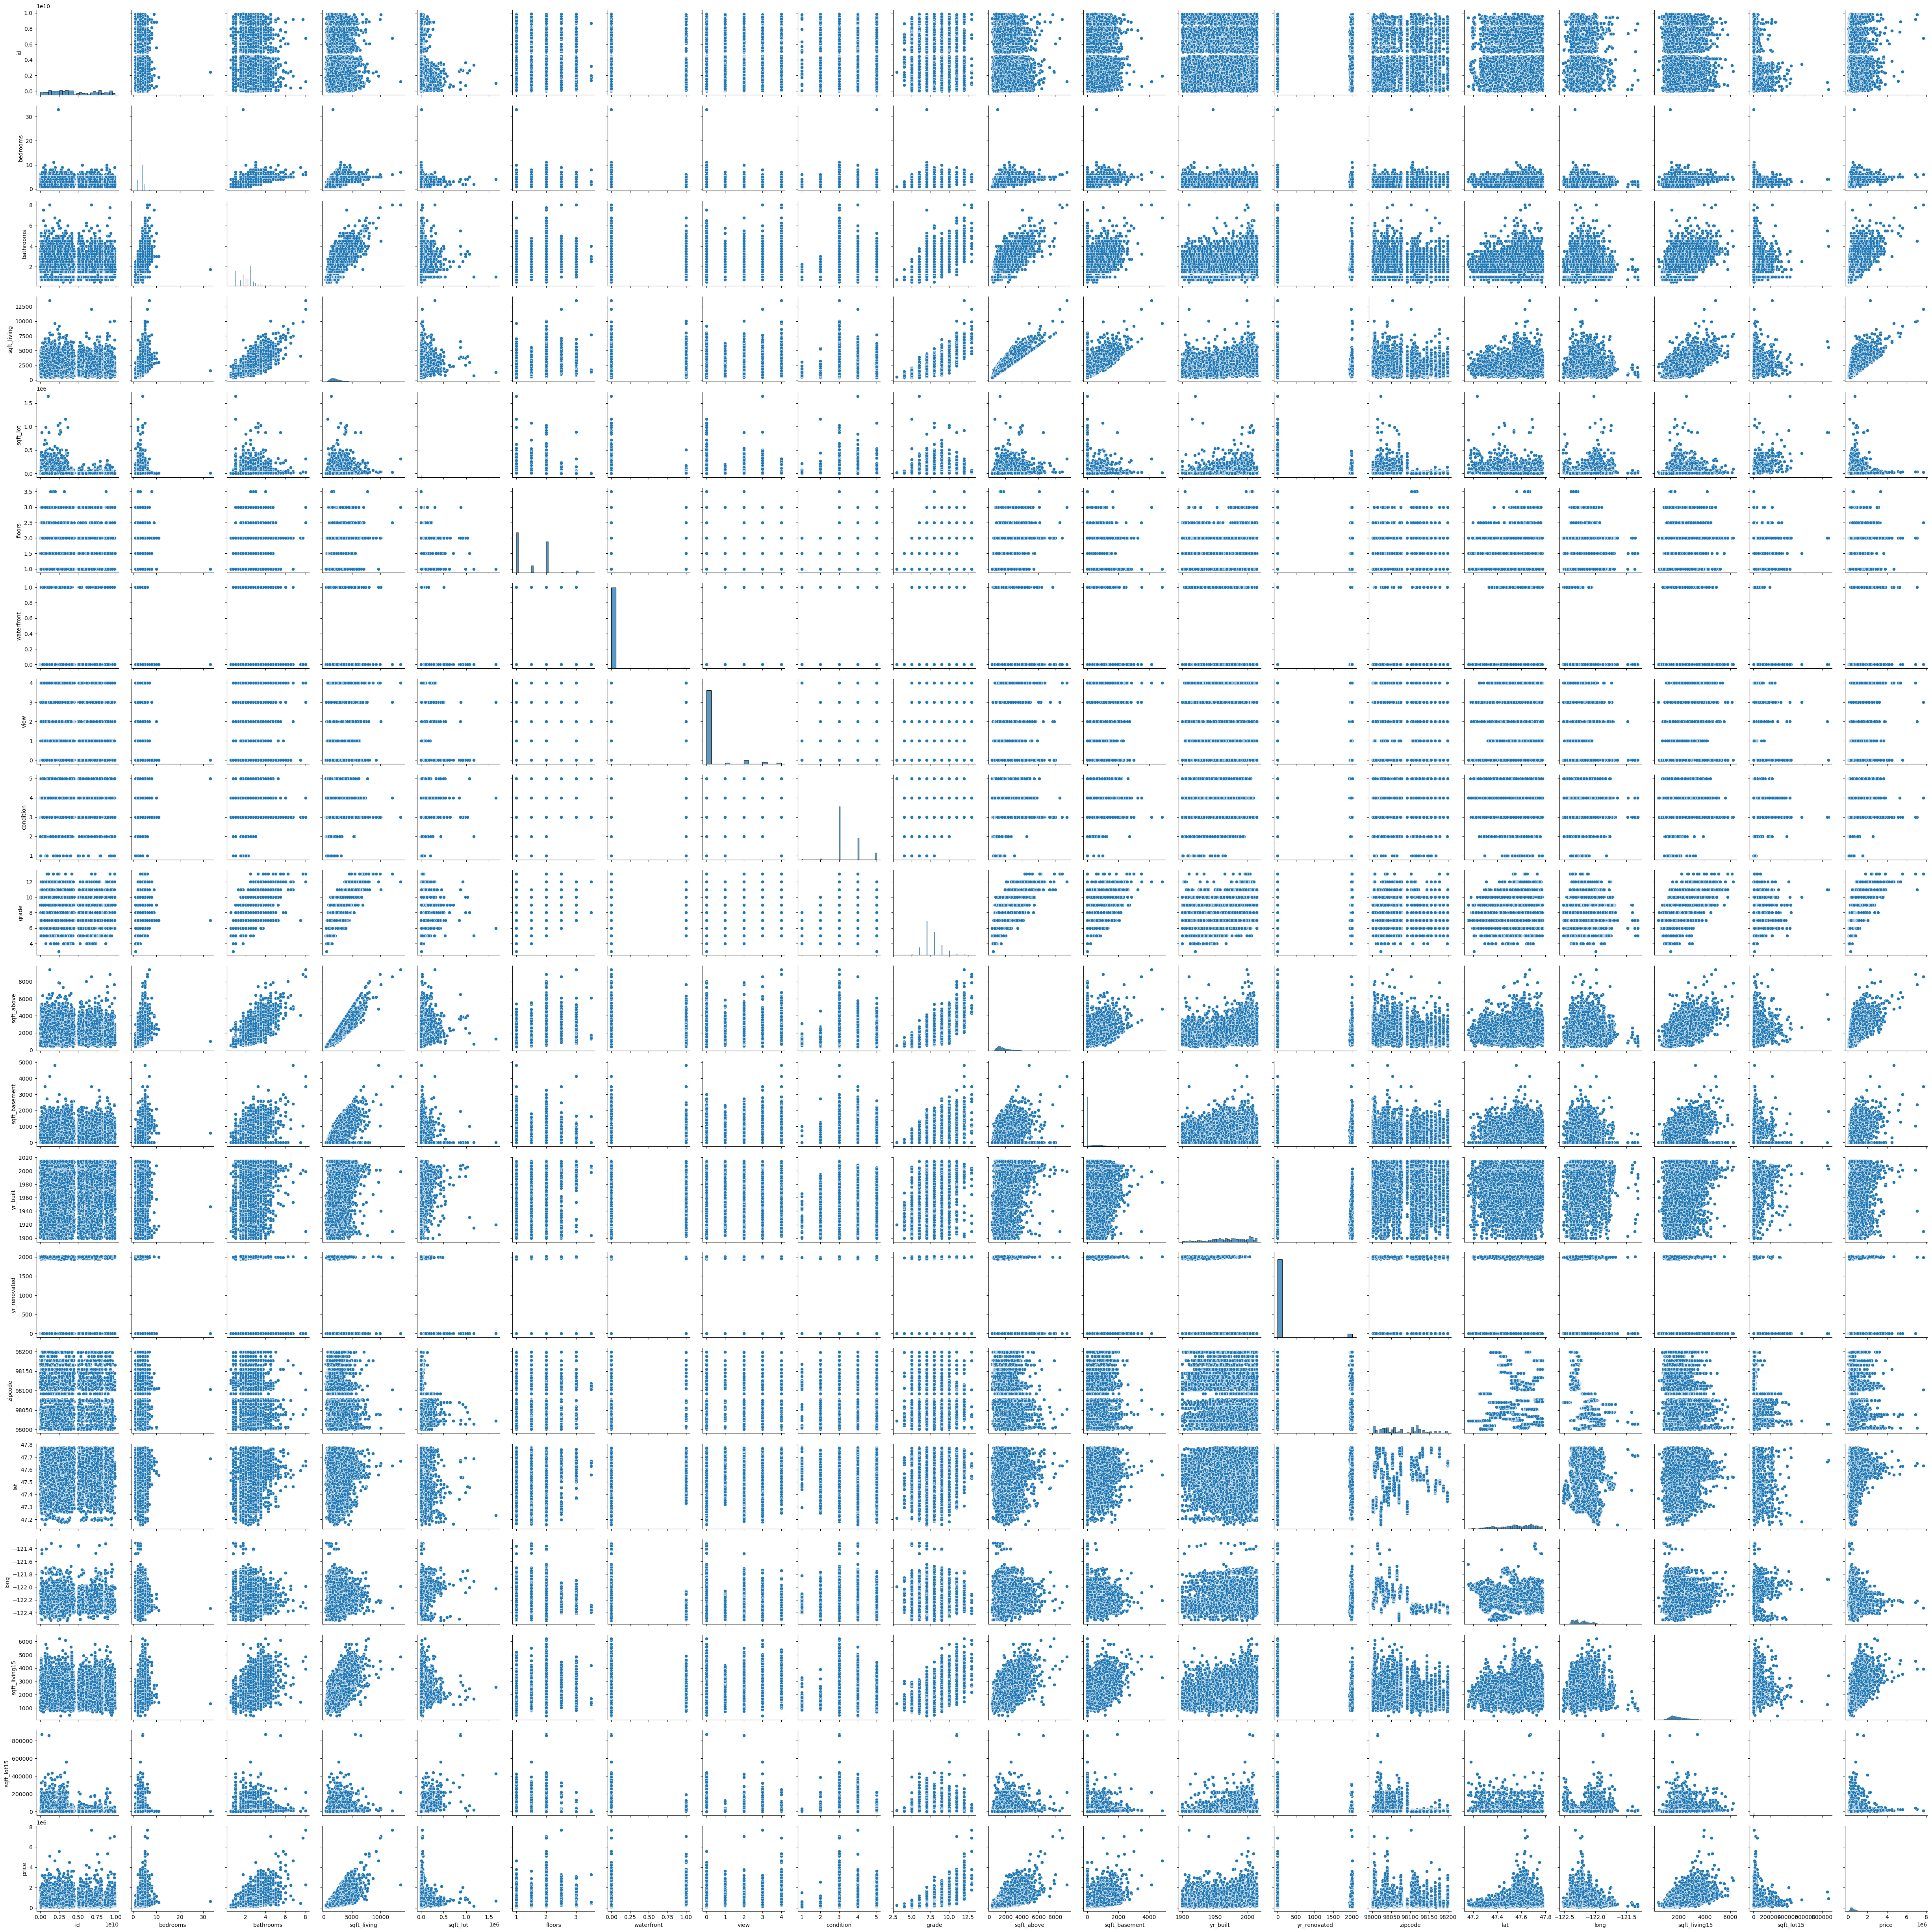

In [52]:
sns.pairplot(df.select_dtypes(np.number))

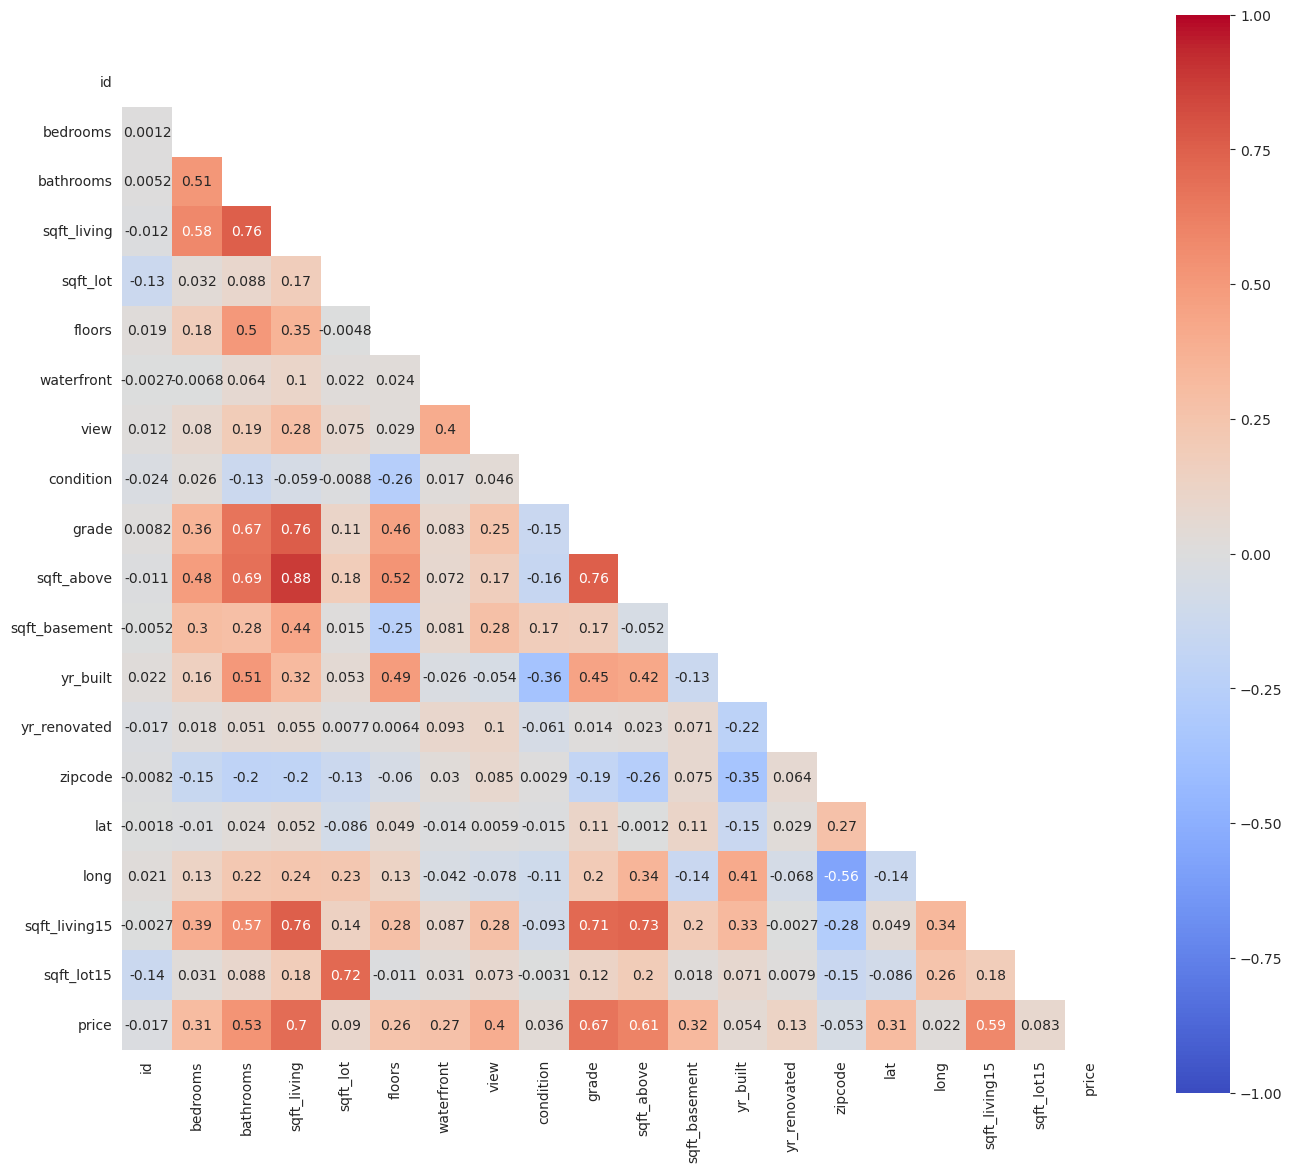

In [53]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [54]:
CORR_THRESH = 0.80
corr_matrix=df.corr().abs()
upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
corrd_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > CORR_THRESH)]
df.drop(corrd_cols,axis=1,inplace=True)
df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement',
       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'price'],
      dtype='object')

In [55]:
df.drop(columns=['sqft_living15', 'sqft_lot15', 'lat', 'long'], inplace=True)

In [56]:
df

id        date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0      7129300520  13/10/2014         3       1.00         1180      5650   
1      6414100192  09/12/2014         3       2.25         2570      7242   
2      5631500400  25/02/2015         2       1.00          770     10000   
3      2487200875  09/12/2014         4       3.00         1960      5000   
4      1954400510  18/02/2015         3       2.00         1680      8080   
...           ...         ...       ...        ...          ...       ...   
21592   263000018  21/05/2014         3       2.50         1530      1131   
21593  6600060120  23/02/2015         4       2.50         2310      5813   
21594  1523300141  23/06/2014         2       0.75         1020      1350   
21595   291310100  16/01/2015         3       2.50         1600      2388   
21596  1523300157  15/10/2014         2       0.75         1020      1076   

       floors  waterfront  view  condition  grade  sqft_basement  yr_built  \
0         1.0           0     0          3      7              0      1955   
1         2.0           0     0          3      7            400      1951   
2         1.0           0     0          3      6              0      1933   
3         1.0           0     0          5      7            910      1965   
4         1.0           0     0          3      8              0      1987   
...       ...         ...   ...        ...    ...            ...       ...   
21592     3.0           0     0          3      8              0      2009   
21593     2.0           0     0          3      8              0      2014   
21594     2.0           0     0          3      7              0      2009   
21595     2.0           0     0          3      8              0      2004   
21596     2.0           0     0          3      7              0      2008   

       yr_renovated  zipcode   price  
0                 0    98178  221900  
1              1991    98125  538000  
2                 0    98028  180000  
3                 0    98136  604000  
4                 0    98074  510000  
...             ...      ...     ...  
21592             0    98103  360000  
21593             0    98146  400000  
21594             0    98144  402101  
21595             0    98027  400000  
21596             0    98144  325000  

[21597 rows x 16 columns]

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>,
        <AxesSubplot:title={'center':'view'}>],
       [<AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>,
        <AxesSubplot:title={'center':'yr_built'}>],
       [<AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'price'}>, <AxesSubplot:>]],
      dtype=object)

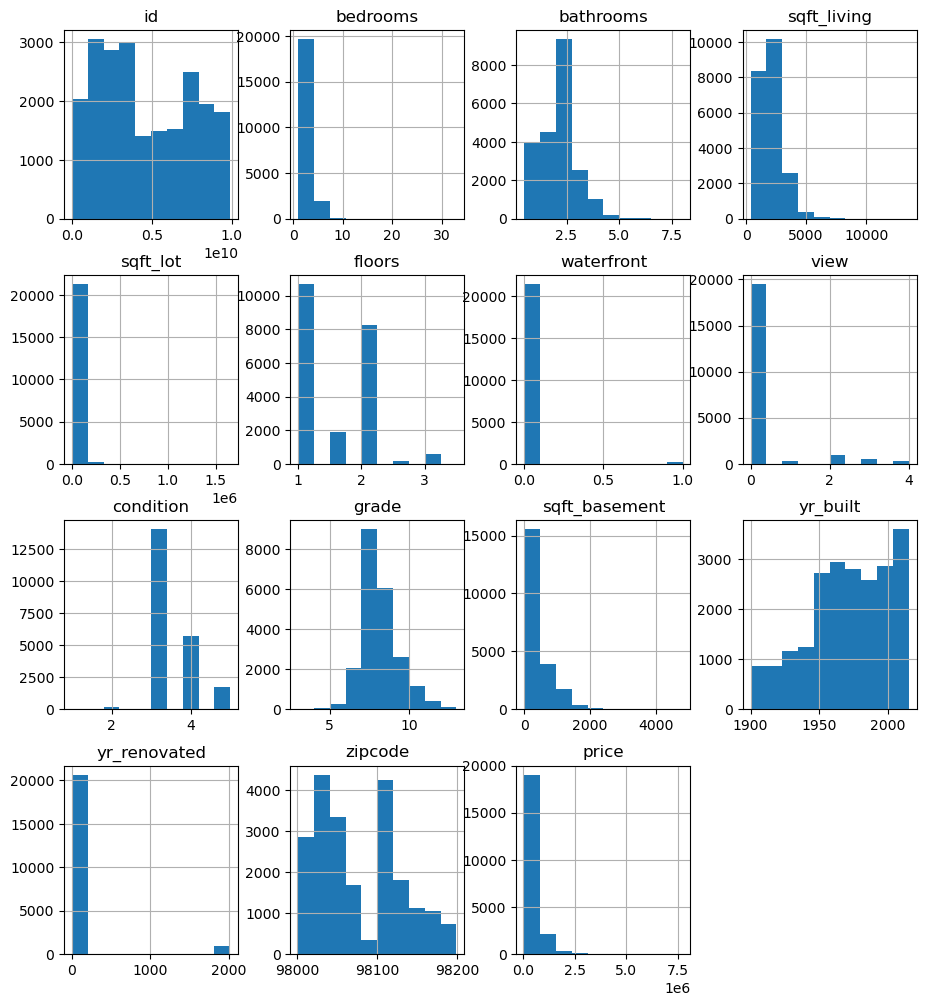

In [57]:
df.hist(figsize=(11,12))

/Users/mm527x/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

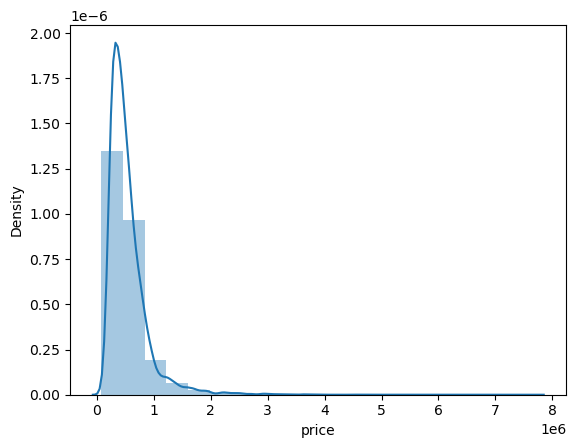

In [58]:
sns.distplot((df['price']), bins=20)

The housing market in Seattle is skewed towards <1m house prices.

In [45]:
X = df.drop('price', axis=1)
y = df.price

In [35]:
X['date'] = X['date'].astype('datetime64[ns]')
#changing date datatype so its numerical

In [36]:
numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(np.object) # there are no categoricals in the dataset

/var/folders/n_/mqs2n84x0k3g_vz_3dbgh2yr0000gp/T/ipykernel_20167/2358487290.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categoricalX = X.select_dtypes(np.object)


In [38]:
X.isna().any()

id               False
date             False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
dtype: bool

In [44]:
X.drop(columns=['date'], inplace=True)
#dropping date just because I want to

KeyError: "['date'] not found in axis"

In [41]:
X.columns

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode'],
      dtype='object')

In [60]:
X

id       date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0      7129300520 2014-10-13         3       1.00         1180      5650   
1      6414100192 2014-09-12         3       2.25         2570      7242   
2      5631500400 2015-02-25         2       1.00          770     10000   
3      2487200875 2014-09-12         4       3.00         1960      5000   
4      1954400510 2015-02-18         3       2.00         1680      8080   
...           ...        ...       ...        ...          ...       ...   
21592   263000018 2014-05-21         3       2.50         1530      1131   
21593  6600060120 2015-02-23         4       2.50         2310      5813   
21594  1523300141 2014-06-23         2       0.75         1020      1350   
21595   291310100 2015-01-16         3       2.50         1600      2388   
21596  1523300157 2014-10-15         2       0.75         1020      1076   

       floors  waterfront  view  condition  grade  sqft_basement  yr_built  \
0         1.0           0     0          3      7              0      1955   
1         2.0           0     0          3      7            400      1951   
2         1.0           0     0          3      6              0      1933   
3         1.0           0     0          5      7            910      1965   
4         1.0           0     0          3      8              0      1987   
...       ...         ...   ...        ...    ...            ...       ...   
21592     3.0           0     0          3      8              0      2009   
21593     2.0           0     0          3      8              0      2014   
21594     2.0           0     0          3      7              0      2009   
21595     2.0           0     0          3      8              0      2004   
21596     2.0           0     0          3      7              0      2008   

       yr_renovated  zipcode  
0                 0    98178  
1              1991    98125  
2                 0    98028  
3                 0    98136  
4                 0    98074  
...             ...      ...  
21592             0    98103  
21593             0    98146  
21594             0    98144  
21595             0    98027  
21596             0    98144  

[21597 rows x 15 columns]

In [61]:
df.waterfront.unique()
# 0 = not on the waterfront
# 1 = on the waterfront

array([0, 1])

In [62]:
df.condition.unique()
# 1 = poor
# 2 = fair
# 3 = good
# 4 = very good
# 5 = excellent

array([3, 5, 4, 1, 2])

In [63]:
df.view.unique()
# 0 = street
# 1 = park
# 2 = skyline
# 3 = mountain view street
# 4 = sea view courtyard

array([0, 3, 4, 2, 1])